In [ ]:
!unzip '/content/drive/MyDrive/KUBIG/데이터분석 스터디/data-science-bowl-2018.zip'

Archive:  /content/drive/MyDrive/KUBIG/데이터분석 스터디/data-science-bowl-2018.zip
  inflating: stage1_sample_submission.csv.zip  
  inflating: stage1_solution.csv.zip  
  inflating: stage1_test.zip         
  inflating: stage1_train.zip        
  inflating: stage1_train_labels.csv.zip  
  inflating: stage2_sample_submission_final.csv.zip  
  inflating: stage2_test_final.zip   


In [ ]:
!mkdir -p /content/input
!mkdir -p /content/input/stage1_train
!mkdir -p /content/input/stage1_test
!mkdir -p /content/input/stage2_test_final
!unzip -q /content/stage1_train.zip -d /content/input/stage1_train
!unzip -q /content/stage1_test.zip -d /content/input/stage1_test
!unzip -q /content/stage1_train_labels.csv.zip -d /content/input
!unzip -q /content/stage2_test_final.zip -d /content/input/stage2_test_final
!unzip -q /content/stage2_sample_submission_final.csv.zip -d /content/input
!unzip -q /content/stage1_solution.csv.zip -d /content/input
!unzip -q /content/stage1_sample_submission.csv.zip -d /content/input

1. preprocess
2. 시각화 (color-space)
3. simple CNN
4. teset data에 적용
5. RLE test data 생성

* RLE은 **"Run Length Encoding"**의 약자로, 이미지나 비디오 데이터를 압축하는 데 사용되는 압축 알고리즘 중 하나
* 이미지에서 연속된 픽셀 값이 반복되는 경우, 그 값을 반복되는 횟수와 함께 저장하여 데이터를 압축 -> 데이터 용량 줄이기

Dataset 소개
* segmented nuclei images (핵)

* **Data의 variation**:  
(1) cell type
(2) magnification
(3) imaging modality (brightfield vs. fluorescence)

* **알고리즘의 목표**: 저런 variation을 generalize해서 nuclei를 segmentation하는 것

* **Image 파일, Mask 파일**
(1) Image 파일: ImageID로 구분
(2) Mask: 각 nucleus가 segmented 된 mask (각 mask가 한 개의 nucleus를 포함)Overlap X (no pixel belongs to two masks)

In [ ]:
import numpy as np
import pandas as pd
from glob import glob
import os
from skimage.io import imread
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
dsb_data_dir = os.path.join('/content/input')
stage_label = 'stage1'

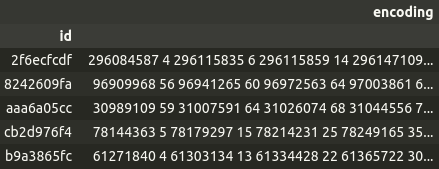

Split(' ')하는 이유: RLE-encoded 된 것을 분리시켜주기 위해

* E.g. '1 3' implies starting at pixel 1 and running a total of 3 pixels (1,2,3).
* '1 3 10 5' implies pixels 1,2,3,10,11,12,13,14 are to be included in the mask
* The pixels are one-indexed and numbered from top to bottom, then left to right: 1 is pixel (1,1), 2 is pixel (2,1), etc

In [ ]:
train_labels = pd.read_csv(os.path.join(dsb_data_dir,'{}_train_labels.csv'.format(stage_label)))
train_labels['EncodedPixels'] = train_labels['EncodedPixels'].map(lambda ep: [int(x) for x in ep.split(' ')])
train_labels.sample(3)

,ImageId,EncodedPixels
17230,947c0d94c8213ac7aaa41c4efc95d854246550298259cf...,"[52371, 5, 52626, 9, 52880, 14, 53135, 16, 533..."
25839,dd54adb80393de7769b9853c0aa2ee9b240905d0e99c59...,"[171565, 9, 172083, 12, 172601, 15, 173119, 17..."
28760,f8e74d4006dd68c1dbe68df7be905835e00d8ba4916f3b...,"[32064, 3, 32319, 5, 32575, 5, 32831, 5, 33088..."


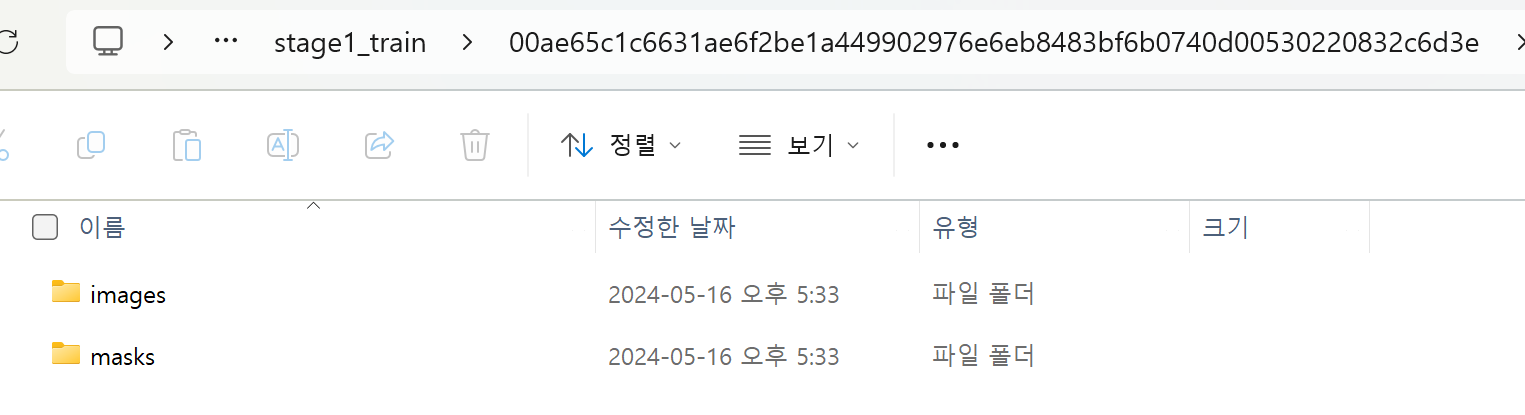

Images

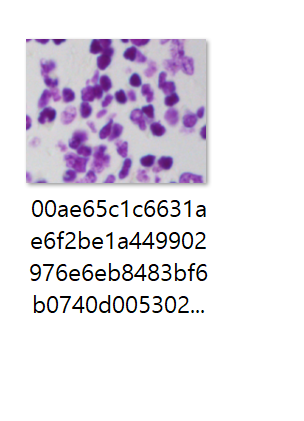

Masks

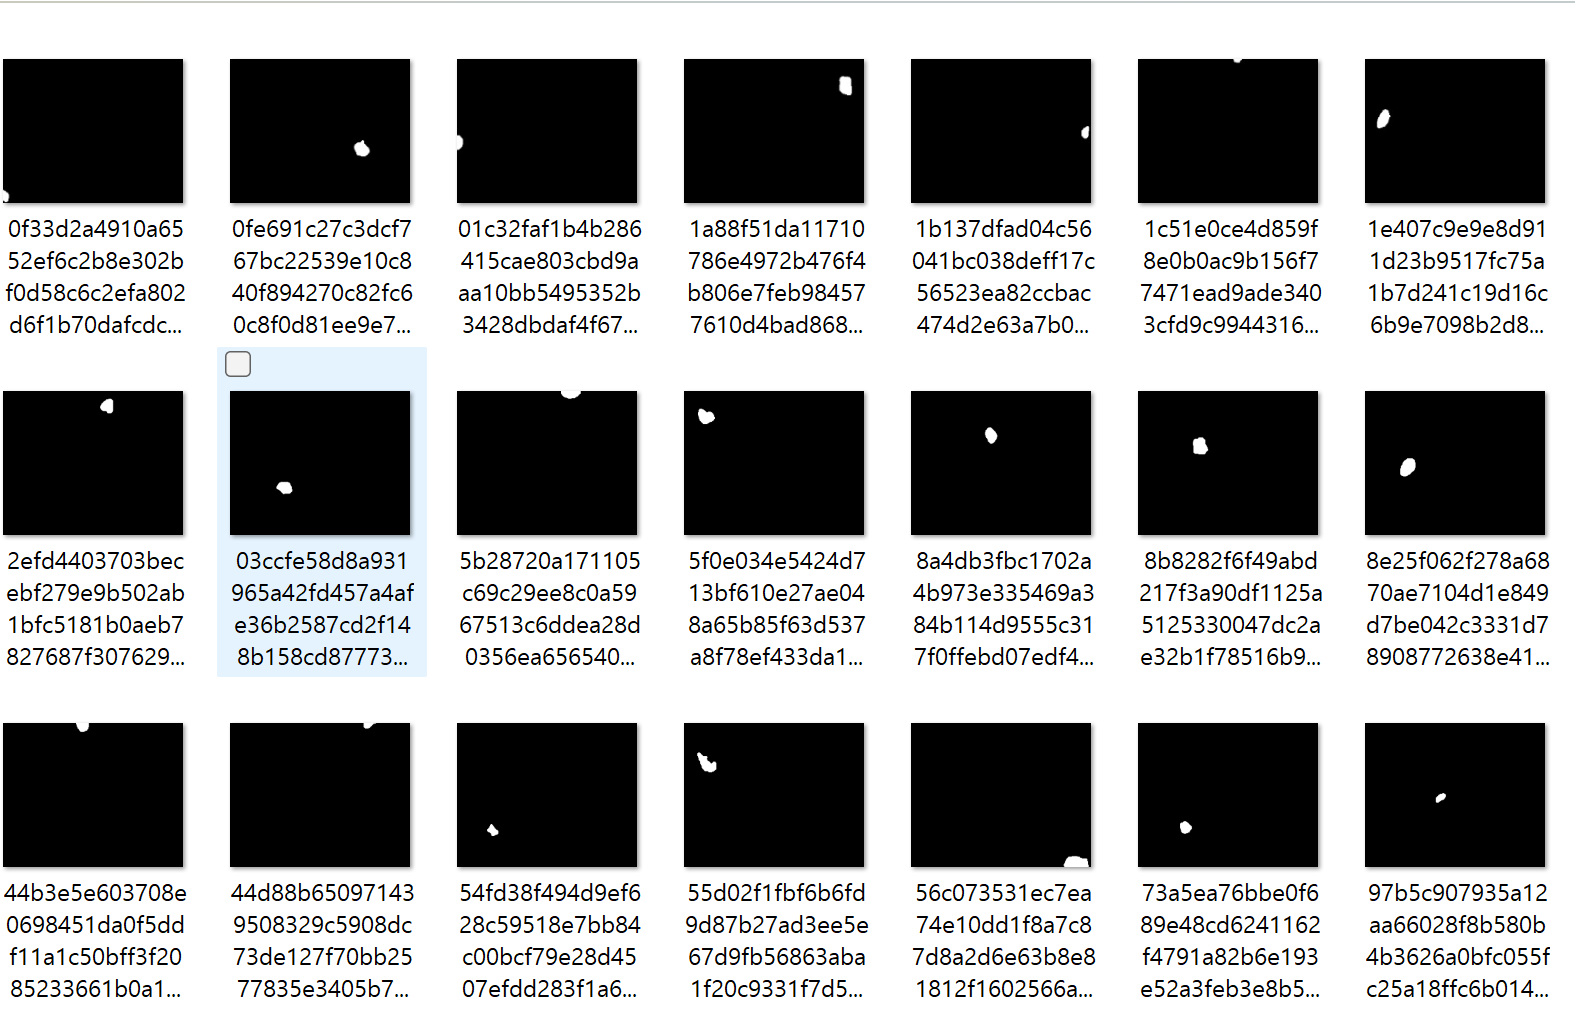

In [ ]:
all_images = glob(os.path.join(dsb_data_dir, 'stage1_*', '*', '*', '*')) #stage1_xxx/xxx/xxx/xxx (-4/-3/-2/-1)
#glob: 조건에 맞는 모든 file path를 읽어들이는 함수
img_df = pd.DataFrame({'path': all_images}) #path column 정의
img_id = lambda in_path: in_path.split('/')[-3] #path의 index 중 마지막 세번째
img_type = lambda in_path: in_path.split('/')[-2] #path의 마지막 2번째
img_group = lambda in_path: in_path.split('/')[-4].split('_')[1] #path의 마지막 4번째, 근데 _를 split해서 뒷부분인 train만
img_stage = lambda in_path: in_path.split('/')[-4].split('_')[0] #path의 마지막 4번째, 근데 _를 split해서 앞부분인 stage1만
img_df['ImageId'] = img_df['path'].map(img_id)
img_df['ImageType'] = img_df['path'].map(img_type)
img_df['TrainingSplit'] = img_df['path'].map(img_group)
img_df['Stage'] = img_df['path'].map(img_stage)
img_df.sample(2)

,path,ImageId,ImageType,TrainingSplit,Stage
20443,/content/input/stage1_train/547ef286ee5f4e5dce...,547ef286ee5f4e5dce533e982e6992ada67b7d727fdd3c...,masks,train,stage1
12726,/content/input/stage1_train/bde3727f3a9e8b2b58...,bde3727f3a9e8b2b58f383ebc762b2157eb50cdbff23e6...,masks,train,stage1


Training data를 생성
* 이미지 읽고 dataframe 생성 -> distinct region으로 놔두기 보단 grouping하기

In [ ]:
%%time
#실행시간 측정
train_df = img_df.query('TrainingSplit=="train"')
#img_df 데이터프레임에서 TrainingSplit 열이 "train"인 행만 필터링하여 train_df에 저장
train_rows = []
group_cols = ['Stage', 'ImageId']
for n_group, n_rows in train_df.groupby(group_cols): #n_group: Stage, ImageID #n_rows: 데이터프레임
    c_row = {col_name: col_value for col_name, col_value in zip(group_cols, n_group)} #모든 행에 대해 Stage, ImageID 추출해서 c_row로 만들기
    c_row['masks'] = n_rows.query('ImageType == "masks"')['path'].values.tolist()  #mask의 path를 추출
    c_row['images'] = n_rows.query('ImageType == "images"')['path'].values.tolist() #images의 path를 추출
    train_rows += [c_row] #train_rows에 추가
train_img_df = pd.DataFrame(train_rows)
IMG_CHANNELS = 3 #RGB이미지
def read_and_stack(in_img_list):
    return np.sum(np.stack([imread(c_img) for c_img in in_img_list], 0), 0)/255.0

    #read_and_stack: in_img_list에 포함된 이미지를 읽어오고 스택하고 정규화하는 게 목적
    #1. imread 함수를 사용하여 이미지를 읽기
    #2. np.stack을 사용하여 이미지를 스택
    #3. np.sum을 사용하여 스택된 이미지의 합을 계산
    #4. 255로 나누어 결과를 정규화

train_img_df['images'] = train_img_df['images'].map(read_and_stack).map(lambda x: x[:,:,:IMG_CHANNELS])
#images 각 요소에 대해 read_and_stack 함수를 적용 -> 필요한 채널 수 3만큼 자름.
train_img_df['masks'] = train_img_df['masks'].map(read_and_stack).map(lambda x: x.astype(int))
#masks 각 요소에 대해 read_and_stack 함수를 적용 -> 정수형으로 변환
train_img_df.sample(1)

CPU times: user 45.2 s, sys: 4.48 s, total: 49.6 s
Wall time: 50.1 s


,Stage,ImageId,masks,images
23,stage1,08275a5b1c2dfcd739e8c4888a5ee2d29f83eccfa75185...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,...","[[[0.3607843137254902, 0.3607843137254902, 0.3..."


시각화

data variation 문제
* brightfield
* fluorescence
-> 나중에 어떻게든 둘이 통합해서 algorithm이 generalize하게 해야 함

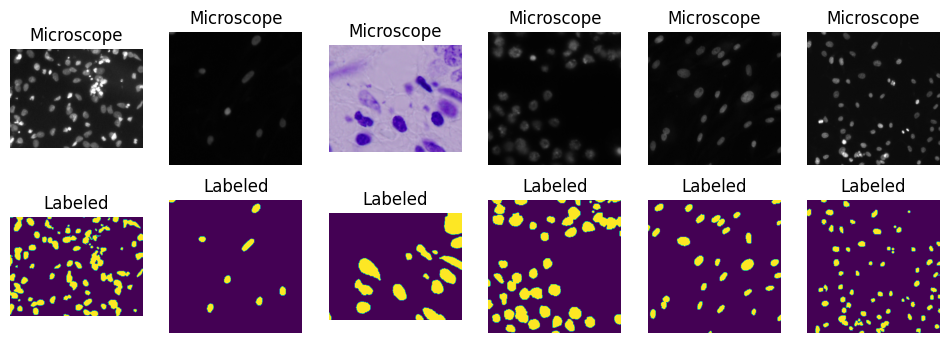

In [ ]:
n_img = 6 #랜덤 이미지 개수
fig, m_axs = plt.subplots(2, n_img, figsize = (12, 4)) #subplot: n_img가 열, 2개의 행 #m_axs: 각 서브플롯의 2D배열
for (_, c_row), (c_im, c_lab) in zip(train_img_df.sample(n_img).iterrows(),
                                     m_axs.T):
  #(_, c_row): 반복된 행의 index와 안의 데이터
  #(c_im, c_lab): subplot의 열 방향으로 이미지를 나란히 배치 -> c_im: Images, c_lab: Mask(label)
    c_im.imshow(c_row['images']) #현재 행의 images 데이터
    c_im.axis('off') #축 숨기기
    c_im.set_title('Microscope')

    c_lab.imshow(c_row['masks']) #현재 행의 mask 데이터
    c_lab.axis('off') #축 숨기기
    c_lab.set_title('Labeled')

Intensity 색 강도 distribution
* group이 forming됨
-> 이미지들이 색상 및 밝기 분포에 따라 유사한 특성을 가지는 그룹으로 나뉨
* 각 group을 분리해서 다르게 다뤄줘야 함
-> 특정 종류의 세포나 구조가 유사한 색상 강도 분포를 가지기 때문일 수 있음
-> 각 그룹이 서로 다른 생물학적 특성을 나타낼 가능성 有
-> e.g.) 특정 그룹의 세포: 특정 질병, but 다른 그룹의 세포: 건강한 상태

* RGB : Labeled ( Red, Green, Blue 채널의 평균값-> 각 색상의 평균 강도)
* Grey :Microscope (이미지의 전체 평균값, 이미지 전체 밝기)
* Red-Blue는 색상 차이? (Red 채널과 Blue 채널 간의 평균적인 차이)

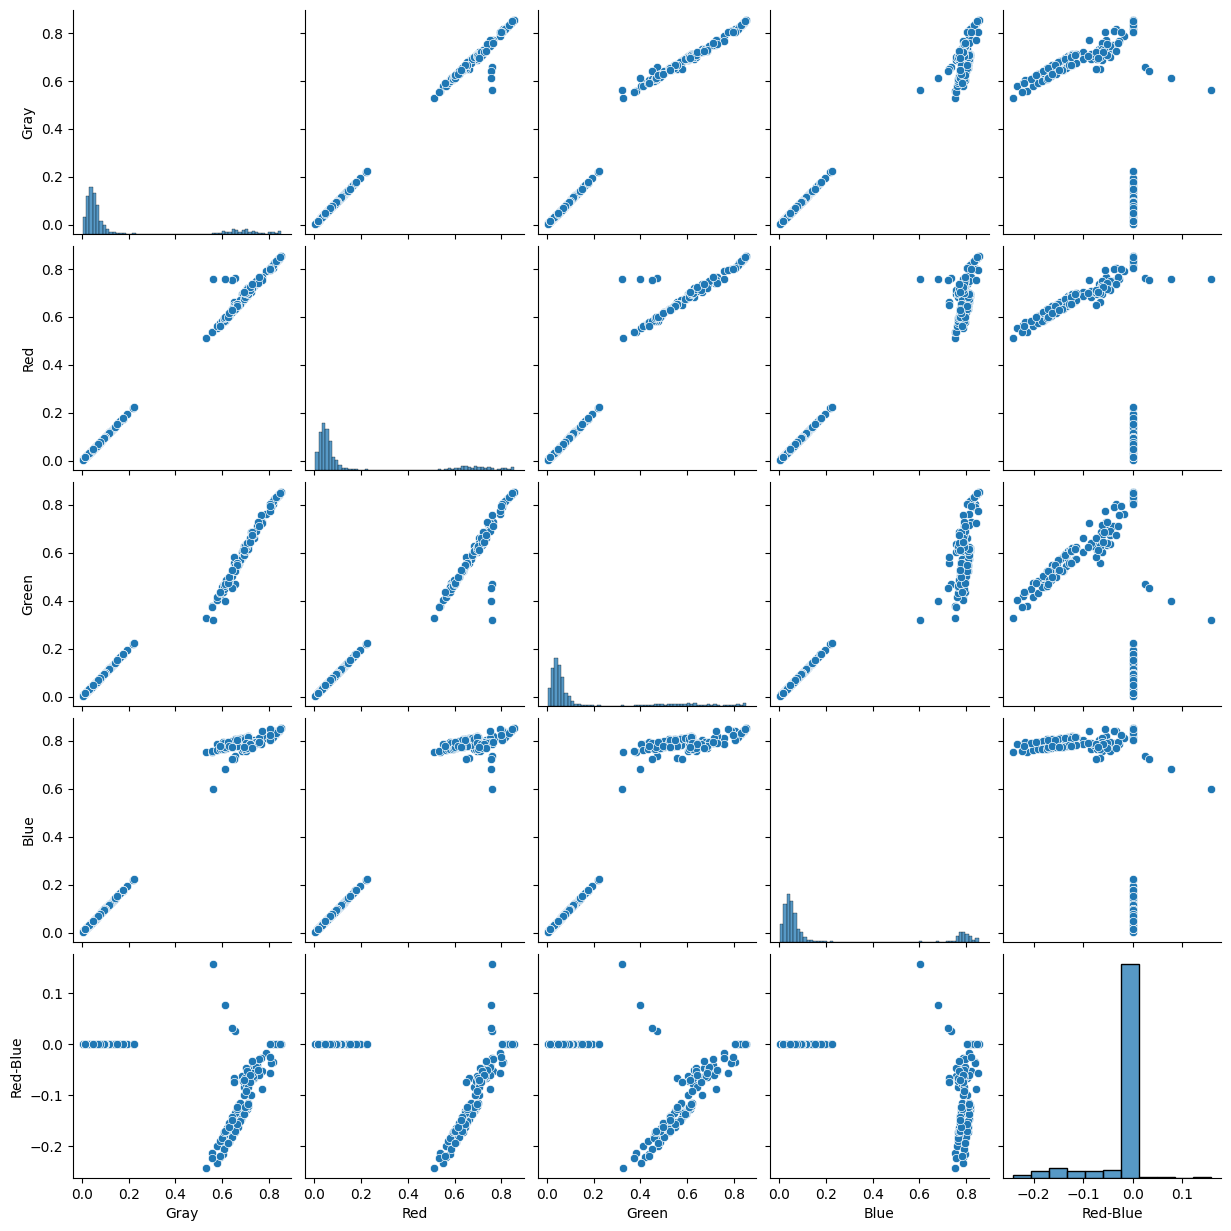

In [ ]:
train_img_df['Red'] = train_img_df['images'].map(lambda x: np.mean(x[:,:,0]))
train_img_df['Green'] = train_img_df['images'].map(lambda x: np.mean(x[:,:,1]))
train_img_df['Blue'] = train_img_df['images'].map(lambda x: np.mean(x[:,:,2]))
train_img_df['Gray'] = train_img_df['images'].map(lambda x: np.mean(x))
train_img_df['Red-Blue'] = train_img_df['images'].map(lambda x: np.mean(x[:,:,0]-x[:,:,2]))
sns.pairplot(train_img_df[['Gray', 'Red', 'Green', 'Blue', 'Red-Blue']])

차원 확인

-> variety in the input images
* 채널은 3으로 고정 but 해상도가 다름
* 각 이미지의 크기(해상도)가 얼마나 다양한지 알 수 있음,, 256*256 크기의 이미지는 334번 카운트
* 이미지의 해상도가 다양하므로, 머신러닝 모델에 입력하기 전에 이미지의 크기를 표준화해야 함 (동일한 해상도로 resize해야 함)

In [ ]:
train_img_df['images'].map(lambda x: x.shape).value_counts()

images
(256, 256, 3)      334
(256, 320, 3)      112
(520, 696, 3)       92
(360, 360, 3)       91
(1024, 1024, 3)     16
(512, 640, 3)       13
(603, 1272, 3)       6
(260, 347, 3)        5
(1040, 1388, 3)      1
Name: count, dtype: int64

###Simple CNN
* batch normalization (normalize input)
* padding으로 문제 간단하게 함

In [ ]:
from keras.models import Sequential
from keras.layers import BatchNormalization, Conv2D, UpSampling2D, Lambda
simple_cnn = Sequential()
simple_cnn.add(BatchNormalization(input_shape = (None, None, IMG_CHANNELS),
                                  name = 'NormalizeInput'))
simple_cnn.add(Conv2D(8, kernel_size = (3,3), padding = 'same'))
#3x3 커널-> 8개의 필터
#padding = 'same'으로 패딩을 추가한건데, 출력 이미지의 크기가 입력 이미지와 동일하도록 함.
# 0 패딩, 네트워크가 깊어질수록 출력 크기가 작아지지 않도록 하는 역할

simple_cnn.add(Conv2D(8, kernel_size = (3,3), padding = 'same'))

#여기까지 기본적인 특징 추출

# Dilation:  dilation_rate = 2는 필터의 receptive field를 확장
#필터 요소 간의 간격: 기본 값은 1이지만, 여기서는 2
# 더 넓은 범위의 특징을 추출
simple_cnn.add(Conv2D(16, kernel_size = (3,3), dilation_rate = 2, padding = 'same'))
#출력: (높이, 너비, 16) 형태의 텐서

#3x3 커널, 16개의 필터
simple_cnn.add(Conv2D(16, kernel_size = (3,3), dilation_rate = 2, padding = 'same'))
simple_cnn.add(Conv2D(32, kernel_size = (3,3), dilation_rate = 3, padding = 'same'))

# 마지막 처리=>최종적으로 1채널 흑백 이미지로 생성
simple_cnn.add(Conv2D(16, kernel_size = (1,1), padding = 'same'))
#1x1 커널, 16개의 필터
simple_cnn.add(Conv2D(1, kernel_size = (1,1), padding = 'same', activation = 'sigmoid'))
#sigmoid로 이미지 출력을 0~1 범위로 제한함.
simple_cnn.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 NormalizeInput (BatchNorma  (None, None, None, 3)     12        
 lization)                                                       
                                                                 
 conv2d (Conv2D)             (None, None, None, 8)     224       
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 8)     584       
                                                                 
 conv2d_2 (Conv2D)           (None, None, None, 16)    1168      
                                                                 
 conv2d_3 (Conv2D)           (None, None, None, 16)    2320      
                                                                 
 conv2d_4 (Conv2D)           (None, None, None, 32)    4640      
                                                        

### 모델 평가: Loss Function
* 캐글 평가 기준: IoU
* 최적화할 loss function: inverse of the DICE score

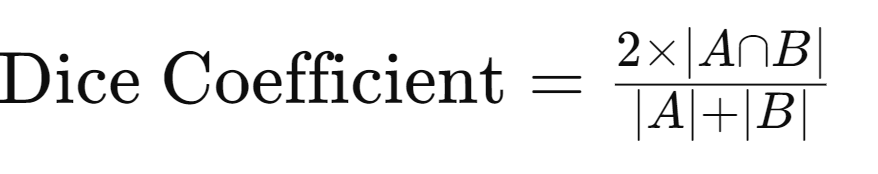

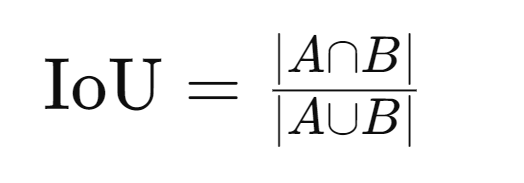

IoU높이기 = Dice Coefficient를 최대화=inverse of dice coefficient를 줄이기
하는 것과 유사함
* 이유: 교집합 영역을 넓히고, 불일치 영역을 최소화하는 효과가 유사

* 근데 왜 굳이 Dice?
* Dice 계수가 예측된 영역과 실제 영역의 균형에 더 민감
* 세그멘테이션 성능을 더 좋게 함
-> Dice 계수는 IoU와 달리 두 배로 곱해져 있기 때문에 더 높은 값의 차이를 강하게 반영함
-> 세그멘테이션 경계에 더 민감해짐.

In [ ]:
from keras import backend as K
smooth = 1. #Dice Coefficient 계산 시 분모가 0이 되는 것을 방지하기 위해 그냥 더해주는 역할임.
def dice_coef(y_true, y_pred): # 실제 값(y_true)과 예측 값(y_pred) 사이의 Dice Coefficient
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred) #둘 다 1차원으로 flatten
    intersection = K.sum(y_true_f * y_pred_f) #교집합 계
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    #Dice Coefficient: 교집합 2배의 값에 smooth를 더하고, 실제 값과 예측 값의 합에 smooth를 더한 값으로 나누어주기
    #위 식에서 smooth만 각각 더해졌다고 보면 됨.
def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)
    #dice_coef 함수의 값을 음수로 변환-> loss function으로 사용
    #모델 최적화 방향= 손실 값을 최소화하는 방향이기 때문.
simple_cnn.compile(optimizer = 'adam',
                   loss = dice_coef_loss,
                   metrics = [dice_coef, 'acc', 'mse'])

#acc: 정확도, mse: 평균 제곱 오차

### Simple Training의 한계:
* 각 image = 각 batch
* batch size = 1
* 한 번에 한 이미지씩 수행

* Batch: 딥러닝 모델을 훈련할 때 한 번에 처리되는 데이터 샘플들의 집합
* 1번의 훈련 단계에서 모델이 처리하는 데이터의 양

In [ ]:
from keras import backend as K
import numpy as np
import pandas as pd

smooth = 1.

def dice_coef(y_true, y_pred):
    y_true_f = K.cast(K.flatten(y_true), 'float32')
    y_pred_f = K.cast(K.flatten(y_pred), 'float32') #소수점형식으로 변환(cast)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

simple_cnn.compile(optimizer='adam',
                   loss=dice_coef_loss,
                   metrics=[dice_coef, 'acc', 'mse'])

def simple_gen():
    while True:
        for _, c_row in train_img_df.iterrows():
            yield np.expand_dims(c_row['images'], 0), np.expand_dims(np.expand_dims(c_row['masks'], -1), 0)

            #train image와 mask를 반환
            # np.expand_dims: 이미지를 0차원으로 확장
            #image: (height, width, channels)
            #0-> 첫 번째 차원에 새로운 축을 추가
            #결과: (height, width, channels) -> (1, height, width, channels)
            #keras모델의 형태는 보통 (batch_size, height, width, channels)인데
            #단일 이미지를 배치로 만들기 위해 첫 번째 축에 배치 차원을 추가한 것
            #그래서 여기서 batch_size는 1이 됨.

            #mask:(height, width)
            #np.expand_dims(c_row['masks'], -1): 마지막 차원에 새로운 축을 추가
            #결과: (height, width) -> (height, width, 1)
            #mask data를 (height, width, channels) 형태로 맞추기 위해 채널 차원을 추가한 것
            #보통 흑백 이미지이므로 채널 수는 1
            #뒤에 0으로 한 번 더 expand_dims:
            #(height, width, 1) -> (1, height, width, 1)

simple_cnn.fit(simple_gen(),
               steps_per_epoch=train_img_df.shape[0], #한 epoch당 train_img_df의 row 수만큼의 스텝 수행
               epochs=3)


Epoch 1/3
670/670 [==============================] - 34s 39ms/step - loss: -0.7141 - dice_coef: 0.7141 - acc: 0.8631 - mse: 0.1272
Epoch 2/3
670/670 [==============================] - 12s 17ms/step - loss: -0.7980 - dice_coef: 0.7980 - acc: 0.8977 - mse: 0.0956
Epoch 3/3
670/670 [==============================] - 11s 16ms/step - loss: -0.8013 - dice_coef: 0.8013 - acc: 0.9001 - mse: 0.0953


### Test에 모델 적용

In [ ]:
%%time
test_df = img_df.query('TrainingSplit=="test"')
test_rows = []
group_cols = ['Stage', 'ImageId']
for n_group, n_rows in test_df.groupby(group_cols):
    c_row = {col_name: col_value for col_name, col_value in zip(group_cols, n_group)}
    c_row['images'] = n_rows.query('ImageType == "images"')['path'].values.tolist()
    test_rows += [c_row]
test_img_df = pd.DataFrame(test_rows)

test_img_df['images'] = test_img_df['images'].map(read_and_stack).map(lambda x: x[:,:,:IMG_CHANNELS])
print(test_img_df.shape[0], 'images to process')
test_img_df.sample(1)

65 images to process
CPU times: user 917 ms, sys: 13.6 ms, total: 931 ms
Wall time: 970 ms


,Stage,ImageId,images
4,stage1,0ed3555a4bd48046d3b63d8baf03a5aa97e523aa483aaa...,"[[[0.054901960784313725, 0.054901960784313725,..."


In [ ]:
%%time
test_img_df['masks'] = test_img_df['images'].map(lambda x: simple_cnn.predict(np.expand_dims(x, 0))[0, :, :, 0])
#np.expand_dims(x, 0)를 통해 images의 x: (height, width, channels)-> (1, height, width, channels) =(batch_size, height, width, channels)
#simple_cnn.predict->(1, height, width, 1) 형태의 4차원 텐서 출력
# [0, :, :, 0]: -> 0번째 배치, 0번째 채널: 1, (height, width) 형태의 2차원 마스크를 반환
# 인덱싱->차원 제거: 배치 차원과 채널 차원을 선택한다는 것 -> 해당 차원이 선택되었으니, 차원에서 제거

1/1 [==============================] - 0s 19ms/step
CPU times: user 7.31 s, sys: 239 ms, total: 7.55 s
Wall time: 7.7 s


Show a few predictions

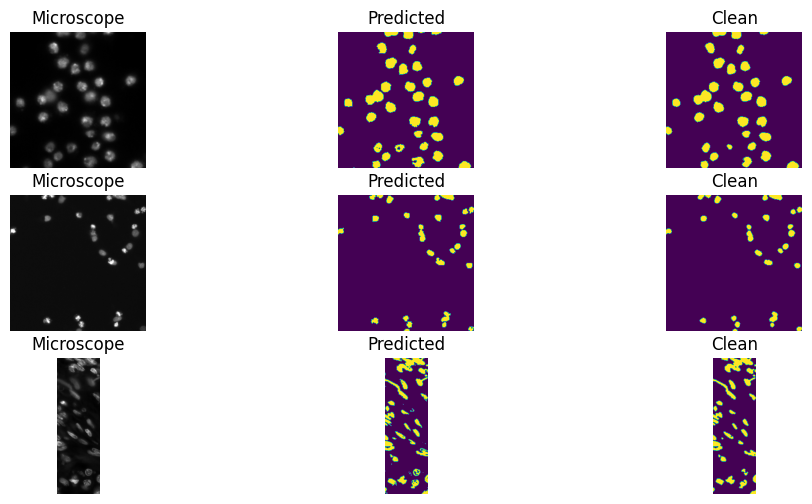

In [ ]:
n_img = 3
from skimage.morphology import closing, opening, disk
def clean_img(x):
    return opening(closing(x, disk(1)), disk(3))
fig, m_axs = plt.subplots(3, n_img, figsize = (12, 6))
for (_, d_row), (c_im, c_lab, c_clean) in zip(test_img_df.sample(n_img).iterrows(),
                                     m_axs):
    c_im.imshow(d_row['images'])
    c_im.axis('off')
    c_im.set_title('Microscope')

    c_lab.imshow(d_row['masks'])
    c_lab.axis('off')
    c_lab.set_title('Predicted')

    c_clean.imshow(clean_img(d_row['masks']))
    c_clean.axis('off')
    c_clean.set_title('Clean')

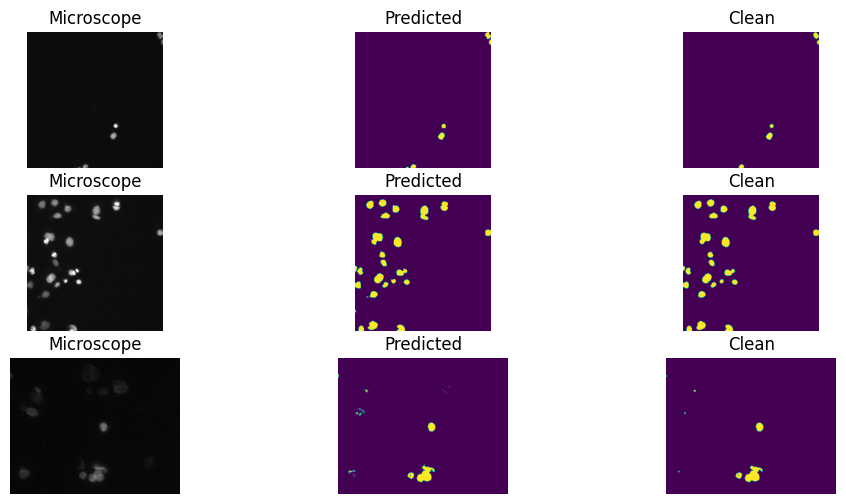

In [ ]:
n_img = 3
from skimage.morphology import closing, opening, disk
def clean_img(x):
    return opening(closing(x, disk(1)), disk(3))
fig, m_axs = plt.subplots(3, n_img, figsize = (12, 6))
for (_, d_row), (c_im, c_lab, c_clean) in zip(test_img_df.sample(n_img).iterrows(),
                                     m_axs):
    c_im.imshow(d_row['images'])
    c_im.axis('off')
    c_im.set_title('Microscope')

    c_lab.imshow(d_row['masks'])
    c_lab.axis('off')
    c_lab.set_title('Predicted')

    c_clean.imshow(clean_img(d_row['masks']))
    c_clean.axis('off')
    c_clean.set_title('Clean')

#skimage.morphology -> 이미지 후처리
# 예측된 마스크에 대해 이미지 후처리 수행 -> (노이즈 제거, 마스크형태 정리)
#closing: 작은 검은색 구멍을 메우기 위해 이미지에 적용 (어두운 노이즈 제거)
#opening: 작은 흰색 점을 제거하기 위해 이미지에 적용 (밝은 노이즈 제거)
#disk(1), disk(3): 구조 요소로 사용하는 원형의 크기
#disk(1)= 반지름이 1 디스크, disk(3)= 반지름이 3인 디스크
#closing(x, disk(1))-> 원소의 형태를 유지하면서 작은 구멍을 메우는 작업
#opening(x, disk(3))-> 이미지에서 작은 점이나 잡음을 제거하는 작업 ->맞닿아있는 것을 분리
#끊어지는 것을 연결할 필요는 X

### RLE encoding
* 목적: segmentation 마스크를 RLE 형식으로 변환하여 제출하는 것

In [ ]:
from skimage.morphology import label #라벨 영역
def rle_encoding(x):
    '''
    x: numpy array of shape (height, width), 1 - mask, 0 - background
    Returns run length as list
    '''
    dots = np.where(x.T.flatten()==1)[0]
    #값이 1인 요소의 인덱스를 찾는데, 결국 마스크의 위치를 의미.
    # x.T.flatten(): 배열을 열 우선(Fortran order, down-then-right) 방식으로 1차원 배열로 변환한다는 의미
    # c order: 행 우선
    #데이터를 열 단위로 처리하므로 segmentation mask에서 연속된 segmentation 부분을 더 자연스럽게 표현?
    run_lengths = []
    prev = -2 #이전 인덱스를 추적
    #dots 배열의 첫 번째 요소가 prev + 1보다 클 경우 새로운 런을 시작하게 되는데,
    # prev가 -2로 설정되면 첫 번째 요소는 항상 prev + 1보다 크게 되니까 새로운 런을 시작할 수 있음
    for b in dots: #마스크 위치에 따라 반복
        if (b>prev+1): run_lengths.extend((b+1, 0)) #이전 인덱스와 새로운 인덱스가 연속하지 않으면 새로운 run을 시
        run_lengths[-1] += 1
        prev = b #이전 인덱스를 현재 인덱스로 업데이트
    return run_lengths

def prob_to_rles(x, cut_off = 0.5): # 확률을 binary로 labeling1*
    lab_img = label(x>cut_off)
    if lab_img.max()<1:
        lab_img[0,0] = 1
        #lab_img 배열이 완전히 0으로만 구성되어 있는 경우
        #(0, 0) 위치에 임의로 1을 설정-> 최소 하나의 레이블을 보장
        #첫 번째 픽셀에 레이블을 설정,  레이블된 객체가 없는 경우(빈 이미지) -> 최소 하나의 예측을 보장함.
    for i in range(1, lab_img.max()+1):
        yield rle_encoding(lab_img==i)

###Train image에 대해 RLE 계산

In [ ]:
_, train_rle_row = next(train_img_df.tail(5).iterrows())
#train_rle_row: 데이터프레임의 마지막 5개 행 중 하나의 행 데이터
train_row_rles = list(prob_to_rles(train_rle_row['masks']))
#train_rle_row의 'masks': prob_to_rles -> RLE 형식으로 변환
#train_row_rles: train_rle_row의 mask에 대한 RLE 인코딩 list가 나옴.

### csv에서 RLE 가져오기

In [ ]:
tl_rles = train_labels.query('ImageId=="{ImageId}"'.format(**train_rle_row))['EncodedPixels']
#위에서 train_labels 해놨던 거의 EncodedPixels->RLE
#=train_rle_row의 'ImageId'에 해당하는 실제 라벨 데이터에서 'EncodedPixels' column
#tl_rles: 해당 이미지의 실제 RLE 인코딩

### RLE 확인 : 비슷할지도... 완벽한 건 아니지만

* 예측된 RLE 인코딩이 실제 RLE 인코딩과 얼마나 잘 일치하는지

In [ ]:
match, mismatch = 0, 0
for img_rle, train_rle in zip(sorted(train_row_rles, key = lambda x: x[0]),
                             sorted(tl_rles, key = lambda x: x[0])):
    for i_x, i_y in zip(img_rle, train_rle):
        if i_x == i_y:
            match += 1 #if i_x == i_y하면 match를 증가
        else:
            mismatch += 1 #아니면 mismatch 증가
print('Matches: %d, Mismatches: %d, Accuracy: %2.1f%%' % (match, mismatch, 100.0*match/(match+mismatch)))

Matches: 360, Mismatches: 0, Accuracy: 100.0%


### 모든 mask에 대해 RLE 계산
* 후처리 (morphological operation) -> clean up images before submission
* remove single pixels, connect nearby regions, etc

In [ ]:
test_img_df['rles'] = test_img_df['masks'].map(clean_img).map(lambda x: list(prob_to_rles(x)))
#위에서 정의한 후처리 함수 clean_Img 적용
#위에서 정의한 prob_to_rles RLE인코딩 함수 적용
#즉, 후처리된 마스크를 RLE 형식으로 변환->rles 컬럼에 저장

In [ ]:
out_pred_list = []
for _, c_row in test_img_df.iterrows(): #test_img_df 데이터프레임의 각 행 반복
    for c_rle in c_row['rles']: #각 행의 rles, RLE 리스트마다 반복
        out_pred_list+=[dict(ImageId=c_row['ImageId'],
                             EncodedPixels = ' '.join(np.array(c_rle).astype(str)))]
                             #EncodedPixels: 각 RLE 인코딩을 문자열로 변환
                             #이미지 ID랑 합쳐서 딕셔너리 형태로 out_pred_list에 추가
out_pred_df = pd.DataFrame(out_pred_list)
print(out_pred_df.shape[0], 'regions found for', test_img_df.shape[0], 'images')
#regions: out_pred_df의 행 수(예측된 영역 수)
#test_img_df의 행 수(이미지 수)를 출력
#예측된 영역 수 & 전체 이미지 수
out_pred_df.sample(3)
#문자열로 변환된 RLE 인코딩

1643 regions found for 65 images


,ImageId,EncodedPixels
499,4be73d68f433869188fe5e7f09c7f681ed51003da6aa5d...,51851 3 52104 8 52358 11 52611 15 52865 17 531...
812,699f2992cd71e2e28cf45f81347ff22e76b37541ce8808...,78156 2 78414 6 78674 6 78933 8 79194 6 79454 ...
626,550450e4bff4036fd671decdc5d42fec23578198d6a2fd...,104607 6 105125 10 105642 14 106160 16 106678 ...


In [ ]:
#out_pred_df[['ImageId', 'EncodedPixels']].to_csv('predictions2.csv', index = False)